In [ ]:
import numpy as np
import sqlite3
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
from scipy import interpolate
from sklearn.cluster import KMeans
from keras.layers import LSTM, GRU
from keras.layers import RepeatVector
from keras.layers import Input
from keras.layers import TimeDistributed
from keras.layers import Dense
from keras.models import Model, load_model
from tensorflow.keras.utils import plot_model
import keras
import os
import datetime
from tqdm import tqdm
from sklearn.cluster import Birch
import joblib
import math
from sklearn import preprocessing


In [ ]:

from google.colab import files
uploaded = files.upload()




Saving FRA40.csv to FRA40.csv


In [ ]:
pip install optuna

     |████████████████████████████████| 308 kB 4.3 MB/s 
     |████████████████████████████████| 81 kB 9.2 MB/s 
     |████████████████████████████████| 210 kB 45.3 MB/s 
     |████████████████████████████████| 78 kB 6.6 MB/s 
     |████████████████████████████████| 150 kB 51.9 MB/s 
     |████████████████████████████████| 113 kB 48.1 MB/s 
     |████████████████████████████████| 49 kB 6.1 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=7c294353d2a7dc5cbdf36ce80864646eadffc393dc4c0949fb366774111750f1
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [ ]:
#Importation des données
import io

df = pd.read_csv(io.BytesIO(uploaded['FRA40.csv']),index_col='date',parse_dates=['date'])
#df = pd.read_csv("/content/drive/MyDrive/FRA40.csv"))

In [ ]:
print(df.head())

                       open    high     low   close  volume  rowid
date                                                              
2010-01-04 07:00:00  3936.0  3947.0  3936.0  3942.0      62      1
2010-01-04 07:05:00  3942.0  3946.0  3941.0  3946.0      10      2
2010-01-04 07:10:00  3946.0  3951.0  3946.0  3950.0      30      3
2010-01-04 07:15:00  3950.0  3950.0  3947.0  3949.0      12      4
2010-01-04 07:20:00  3949.0  3949.0  3947.0  3948.0      23      5


In [ ]:
data_sequences = df[['open', 'high', 'low', 'close', 'volume']]


longueur = 48
echantillon = 8
nbPoints = 15000

n_in = echantillon
latent_dim = 2
input_dim = 1


openDf = df['open'].tolist()


# Liste va contenir les séquences de 8 points sur 4 heures

Liste = []
for i in range(0,len(openDf)-longueur,longueur):
    l = openDf[i:i+longueur]
    lComp = []
    for k in range(0,len(l),math.floor(len(l)/echantillon)):
        lComp.append(l[k])
    Liste.append(np.array(lComp))

#On normalise les séquences de 8 points pour pouvoir les adapter aux modèles

Liste = np.array([preprocessing.scale(l) for l in Liste])
Liste = np.reshape(Liste,(len(Liste),echantillon, input_dim))







In [ ]:
import optuna

#Utilisation du modèle Optuna pour déterminer les meilleurs paramètres pour minimiser l'erreur de reconstruction

def objective(trial):
    # Clear clutter from previous Keras session graphs.
    param = { 'epochs':trial.suggest_int('epochs', 1,400), 'batch_size' : trial.suggest_int('batch_size', 1,120)}
    inputs = Input(shape = (n_in, input_dim))
    encoder = LSTM(latent_dim, activation = 'relu')(inputs)
    decoder = RepeatVector(n_in)(encoder)
    decoder = LSTM(latent_dim, activation='relu', return_sequences=True)(decoder)
    decoder = TimeDistributed(Dense(input_dim))(decoder)
    encoder_model = Model(inputs=inputs, outputs=[encoder])
    model = Model(inputs=inputs, outputs=[decoder])

    model.compile(optimizer='adam', loss='mse')
    history = model.fit(Liste,Liste, validation_split=0.05, epochs=param['epochs'], batch_size=param['batch_size'], verbose=1, shuffle=True)
    # Evaluate the model accuracy on the validation set.
    return history.history['val_loss'][-1]


if __name__ == "__main__":

    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=1, timeout=600)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

ModuleNotFoundError: ignored

In [ ]:
inputs = Input(shape = (n_in, input_dim))
encoder = LSTM(latent_dim, activation = 'relu')(inputs)
decoder = RepeatVector(n_in)(encoder)
decoder = LSTM(latent_dim, activation='relu', return_sequences=True)(decoder)
decoder = TimeDistributed(Dense(input_dim))(decoder)
encoder_model = Model(inputs=inputs, outputs=[encoder])
model = Model(inputs=inputs, outputs=[decoder])

model.compile(optimizer='adam', loss='mse')
history = model.fit(Liste,Liste, validation_split=0.05, epochs=50, batch_size=16, verbose=1, shuffle=True)
decoded_liste = model.predict(Liste)

Epoch 1/50
601/601 [==============================] - 7s 8ms/step - loss: 0.9023 - val_loss: 0.8333
Epoch 2/50
601/601 [==============================] - 4s 7ms/step - loss: 0.8530 - val_loss: 0.8250
Epoch 3/50
601/601 [==============================] - 4s 7ms/step - loss: 0.8117 - val_loss: 0.7604
Epoch 4/50
601/601 [==============================] - 5s 8ms/step - loss: 0.7352 - val_loss: 0.6991
Epoch 5/50
601/601 [==============================] - 4s 7ms/step - loss: 0.6763 - val_loss: 0.6527
Epoch 6/50
601/601 [==============================] - 4s 7ms/step - loss: 0.6475 - val_loss: 0.6358
Epoch 7/50
601/601 [==============================] - 4s 7ms/step - loss: 0.6345 - val_loss: 0.6276
Epoch 8/50
601/601 [==============================] - 4s 7ms/step - loss: 0.6256 - val_loss: 0.6217
Epoch 9/50
601/601 [==============================] - 4s 7ms/step - loss: 0.6184 - val_loss: 0.6194
Epoch 10/50
601/601 [==============================] - 4s 7ms/step - loss: 0.6112 - val_loss: 0.6143

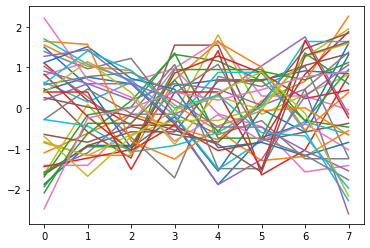

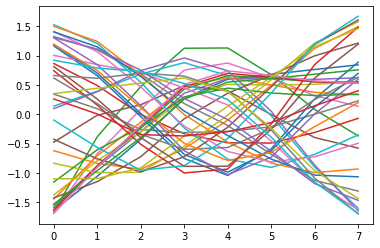

In [ ]:
#Affichage des courbes avant et après passage de l'autoencodeur

for i in range(40):
  plt.plot(Liste[i])

plt.show()



for i in range(40):
  plt.plot(decoded_liste[i])

plt.show()

In [ ]:


val_loss_finale = history.history['val_loss'][-1]
val_loss_finale

0.3593730032444

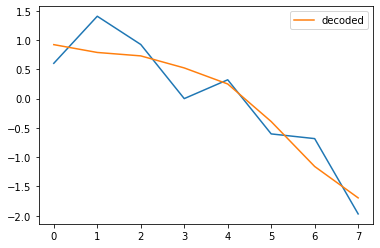

In [ ]:
#Affichage superposé de la séquence originelle et de la séquence décodée

i = np.random.randint(1, 150)
plt.plot(Liste[i])
plt.plot(decoded_liste[i], label = 'decoded')
plt.legend()

In [ ]:
#espace latent


def espace_latent(val_split, nb_epochs, b_size):
  inputs = Input(shape = (n_in, input_dim))
  encoder = LSTM(latent_dim, activation = 'relu')(inputs)
  decoder = RepeatVector(n_in)(encoder)
  decoder = LSTM(latent_dim, activation='relu', return_sequences=True)(decoder)
  decoder = TimeDistributed(Dense(input_dim))(decoder)
  encoder_model = Model(inputs=inputs, outputs=[encoder])
  model = Model(inputs=inputs, outputs=[decoder])
  model.compile(optimizer='adam', loss='mse')
  model.fit(Liste,Liste, validation_split=val_split, epochs=nb_epochs, batch_size=b_size, verbose=1, shuffle=True)
  latent = encoder_model.predict(Liste)
  return latent


def centroid(latent):
  centroid = [0]*latent_dim
  for j in range(latent_dim):
    for i in range(len(latent)):
      centroid[j] += latent[i][j]
  centroid = [k/len(latent) for k in centroid]

  return centroid



In [ ]:
centroides = []

for i in range(10):
  latent = espace_latent(0.2, 30, 200)
  centroides.append(centroid(latent))

x = [centroid[0] for centroid in centroides]
y = [centroid[1] for centroid in centroides]

Epoch 1/30
41/41 [==============================] - 3s 18ms/step - loss: 1.0000 - val_loss: 1.0000
Epoch 2/30
41/41 [==============================] - 0s 9ms/step - loss: 1.0000 - val_loss: 1.0000
Epoch 3/30
41/41 [==============================] - 0s 10ms/step - loss: 1.0000 - val_loss: 1.0000
Epoch 4/30
41/41 [==============================] - 0s 9ms/step - loss: 1.0000 - val_loss: 1.0000
Epoch 5/30
41/41 [==============================] - 0s 9ms/step - loss: 1.0000 - val_loss: 1.0000
Epoch 6/30
41/41 [==============================] - 0s 9ms/step - loss: 1.0000 - val_loss: 1.0000
Epoch 7/30
41/41 [==============================] - 0s 10ms/step - loss: 1.0000 - val_loss: 1.0000
Epoch 8/30
41/41 [==============================] - 0s 9ms/step - loss: 1.0000 - val_loss: 1.0000
Epoch 9/30
41/41 [==============================] - 0s 9ms/step - loss: 1.0000 - val_loss: 1.0000
Epoch 10/30
41/41 [==============================] - 0s 9ms/step - loss: 1.0000 - val_loss: 1.0000
Epoch 11/30
41/4

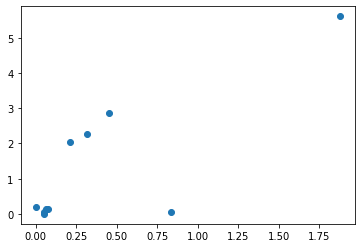

In [ ]:
#Sur 10 itérations, dispersion des centroïdes

plt.scatter(x,y)

Epoch 1/30
68/68 [==============================] - 4s 14ms/step - loss: 0.9974 - val_loss: 0.9910
Epoch 2/30
68/68 [==============================] - 1s 8ms/step - loss: 0.9673 - val_loss: 0.9204
Epoch 3/30
68/68 [==============================] - 1s 9ms/step - loss: 0.9052 - val_loss: 0.8816
Epoch 4/30
68/68 [==============================] - 1s 8ms/step - loss: 0.8777 - val_loss: 0.8565
Epoch 5/30
68/68 [==============================] - 1s 8ms/step - loss: 0.8474 - val_loss: 0.8204
Epoch 6/30
68/68 [==============================] - 1s 9ms/step - loss: 0.8143 - val_loss: 0.7981
Epoch 7/30
68/68 [==============================] - 1s 9ms/step - loss: 0.7957 - val_loss: 0.7776
Epoch 8/30
68/68 [==============================] - 1s 9ms/step - loss: 0.7658 - val_loss: 0.7294
Epoch 9/30
68/68 [==============================] - 1s 9ms/step - loss: 0.7045 - val_loss: 0.6737
Epoch 10/30
68/68 [==============================] - 1s 9ms/step - loss: 0.6589 - val_loss: 0.6327
Epoch 11/30
68/68 

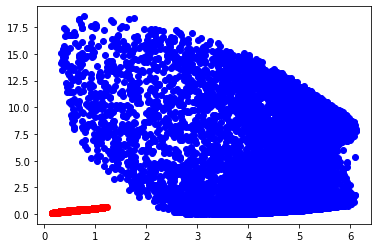

In [ ]:
#Sur 2 itérations, les 2 espaces latents peuvent être complètement différents

latent1 = espace_latent(0.2, 30, 120)
latent2 = espace_latent(0.2, 30, 120)

x1 = [vecteur[0] for vecteur in latent1]
y1 = [vecteur[1] for vecteur in latent1]
x2 = [vecteur[0] for vecteur in latent2]
y2 = [vecteur[1] for vecteur in latent2]

plt.scatter(x1, y1, color = 'b')
plt.scatter(x2, y2, color = 'r')
plt.show()


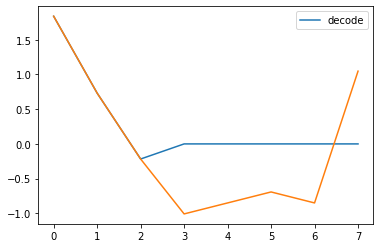

In [ ]:
#Une autre forme de réduction de dimmensionnalité : la transformation en cos, puis on ne garde que les prmières coordonnées

import scipy

coordonnees = scipy.fftpack.dct(Liste, norm = 'ortho')

for i in range(3,8):
  coordonnees[:,i] = 0

decode = scipy.fftpack.idct(coordonnees, norm = 'ortho')

i = np.random.randint(1, 150)
plt.plot(decode[i], label ='decode')
plt.plot(Liste[i])
plt.legend()

In [ ]:
from keras.layers import Lambda
from keras import backend as K
import tensorflow as tf

def create_lstm_vae(input_dim, 
    timesteps, 
    intermediate_dim, 
    latent_dim,
    epsilon_std=1.):

    x = Input(shape=(1, 8))

    # LSTM encoding
    h = LSTM(intermediate_dim)(x)

    # VAE Z layer
    z_mean = Dense(latent_dim)(h)
    z_log_sigma = Dense(latent_dim)(h)
    
    def sampling(args):
        z_mean, z_log_var = args
        epsilon = K.random_normal(shape=K.shape(z_mean), mean=0.,
                                stddev=epsilon_std)
        return z_mean + K.exp(z_log_var / 2) * epsilon

    # note that "output_shape" isn't necessary with the TensorFlow backend
    # so you could write `Lambda(sampling)([z_mean, z_log_sigma])`
    z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_sigma])
    
    # decoded LSTM layer
    decoder_h = LSTM(intermediate_dim, return_sequences=True)
    decoder_mean = LSTM(input_dim, return_sequences=True)

    h_decoded = RepeatVector(timesteps)(z)
    h_decoded = decoder_h(h_decoded)

    # decoded layer
    x_decoded_mean = decoder_mean(h_decoded)
    
    # end-to-end autoencoder
    vae = Model(x, x_decoded_mean)

    # encoder, from inputs to latent space
    encoder = Model(x, z_mean)

    # generator, from latent space to reconstructed inputs
    decoder_input = Input(shape=(latent_dim,))

    _h_decoded = RepeatVector(timesteps)(decoder_input)
    _h_decoded = decoder_h(_h_decoded)

    _x_decoded_mean = decoder_mean(_h_decoded)
    generator = Model(decoder_input, _x_decoded_mean)
    
    def vae_loss(x, x_decoded_mean):
        #xent_loss = np.sum(tf.square(x - x_decoded_mean))
        xent_loss =4
        kl_loss = - 0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma))
        loss = xent_loss + 0.05*kl_loss
        return loss
    adam = tf.keras.optimizers.Adam(learning_rate=0.03, beta_1=0.9, beta_2=0.999, amsgrad=False, decay=0.005)
    vae.compile(optimizer=adam, loss=vae_loss)
    
    return vae, encoder, generator



In [ ]:
print(Liste.shape)

Liste = np.reshape(Liste, (10113, -1, 8))

print(Liste.shape)


(10113, 8, 1)
(10113, 1, 8)


In [ ]:


vae, enc, gen = create_lstm_vae(8 , 
    timesteps=n_in, 
    intermediate_dim=5,
    latent_dim=3,
    epsilon_std=1.)


vae.fit(Liste, Liste, epochs = 10, batch_size = 50, validation_split = 0.2)

AttributeError: ignored